<a href="https://colab.research.google.com/github/cc-ca/projet-impression-3d/blob/main/projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports préliminaires (librairies et dataset)

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import numpy as np

Here is the [link to the dataset](https://www.kaggle.com/datasets/totolvroum/3d-printing-defects). It includes a mix of images sourced from the internet depicting various situations, along with pictures taken of our printers at school.


You need to add a shorcut to the dataset on your Google Drive if you want to use it with collab.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# On se déplace dans notre espace de travail.
# Prévoir le dossier où se placer ou modifier le chemin ci-dessous.
%cd "/content/gdrive/MyDrive/projet impression 3d"

/content/gdrive/MyDrive/projet impression 3d


# Prepare data

In [6]:
dataset_path = 'dataset_binaire_sans_bed3' # dataset path
RESIZE_SIZE = (255, 255)

In [7]:
#display how the images are process
def resize_and_display_images(directory):
    if not os.path.exists(directory):
        print(f"Le dossier {directory} n'existe pas.")
        return
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if not file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
            continue
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Erreur de lecture de l'image {file_path}")
            continue
        resized_image = cv2.resize(image, RESIZE_SIZE)
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        plt.imshow(resized_image)
        plt.title(f"Image: {filename}")
        plt.axis('off')
        plt.show()

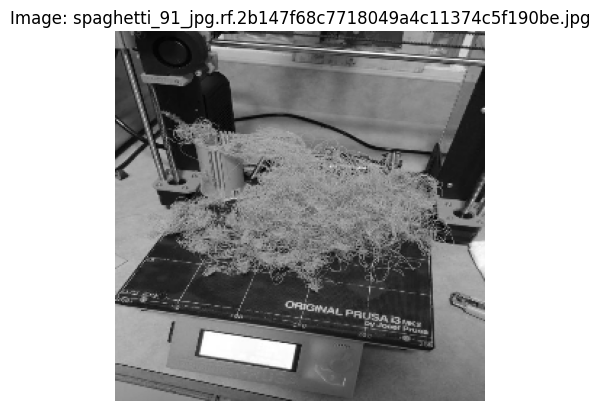

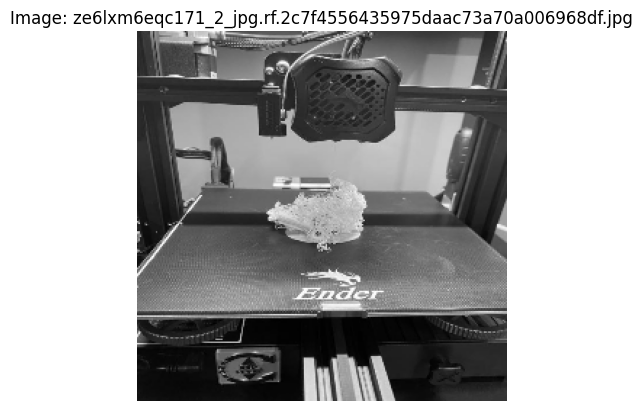

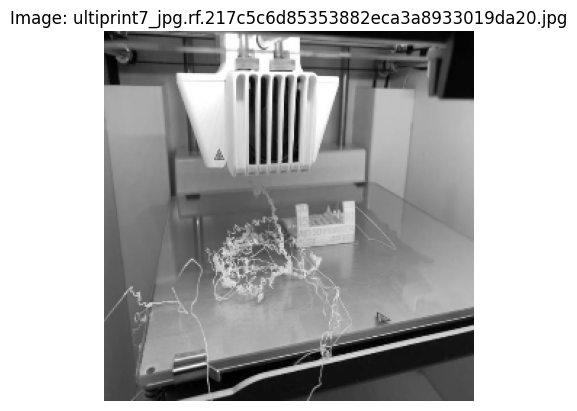

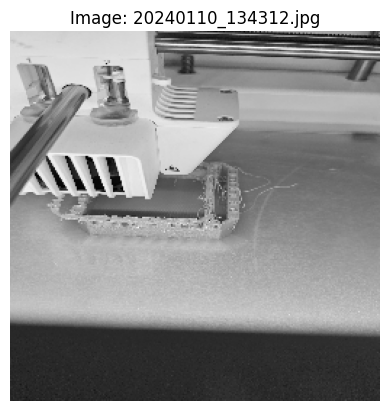

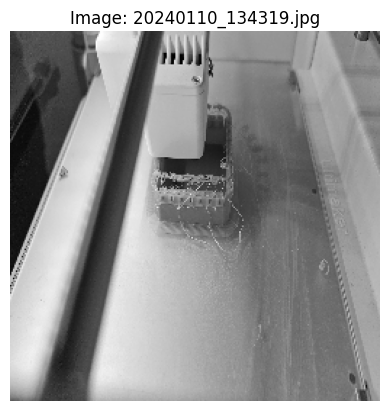

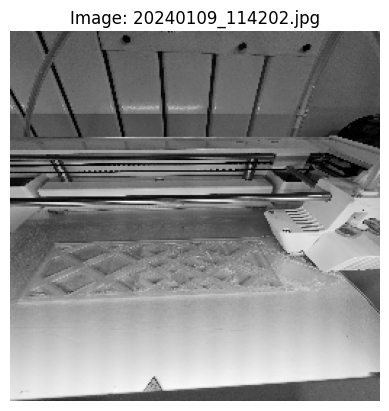

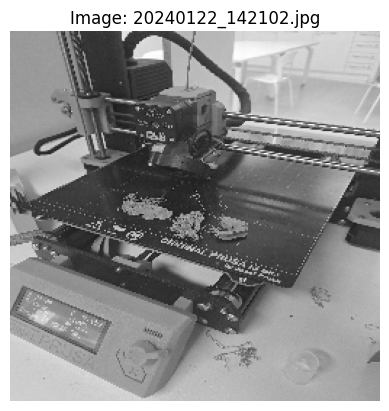

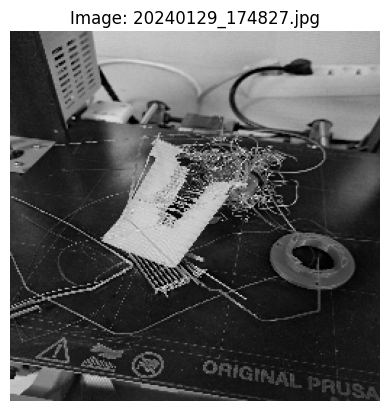

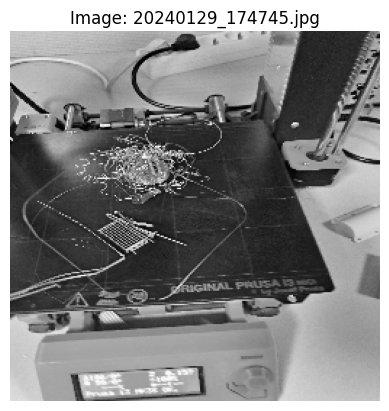

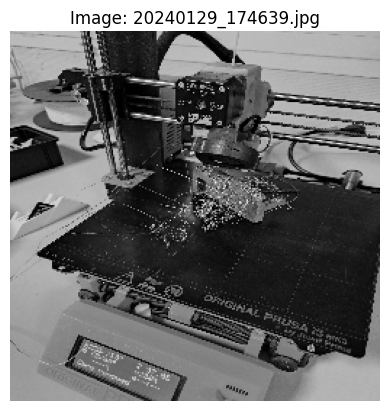

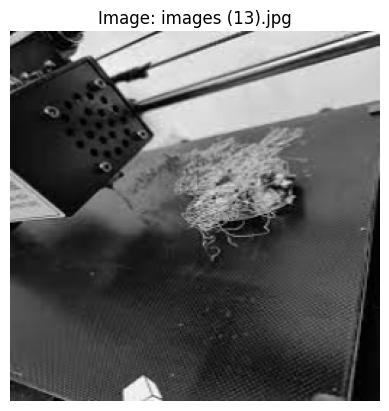

In [8]:
directory = 'testspaghetti'
resize_and_display_images(directory)

In [9]:
def load_data(dataset_path):
    data = []
    labels = []
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            label = folder.lower()
            print(label)
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, RESIZE_SIZE)
                data.append(img)
                labels.append(label)
    data = np.array(data) / 255.0    # Normalise pixel values
    labels = np.array(labels)
    return data, labels

In [10]:
def shuffle_data(data, labels):
    combined_data = list(zip(data,labels))
    random.shuffle(combined_data)
    data,labels = zip(*combined_data)
    labels = np.array(labels)
    data = np.array(data)
    return data, labels

In [11]:
data, labels = load_data(dataset_path)

1
0


In [12]:
# mapping dictonary
categorie_mapping = {
    "0": 0,#no defect
    "1": 1,#defect
}

labels = np.array([categorie_mapping[c] for c in labels])

In [13]:
print('dataset size: ', len(labels))
print('last label: ', labels[-1])

dataset size:  404
last label:  0


In [14]:
data, labels = shuffle_data(data, labels)

In [15]:
#after shuffle
print('dataset size: ', len(labels))
print('last label: ', labels[-1])

dataset size:  404
last label:  0


# Création du modèle

In [16]:
# define model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(*RESIZE_SIZE, 1)),
    BatchNormalization(),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(len(categorie_mapping), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 255, 255, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 255, 255, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 255, 255, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                        

In [17]:
from keras.callbacks import ModelCheckpoint

# train with checkpoint method
#checkpoint = ModelCheckpoint('meilleur_modele.h5', monitor='val_accuracy', save_best_only=True)

In [72]:
#train model
model.fit(data, labels, epochs=1, validation_split=0.2, batch_size=8)
#model.fit(data, labels, epochs=100, validation_split=0.2, batch_size=8, callbacks=[checkpoint])

41/41 [==============================] - 3s 72ms/step - loss: 0.1880 - accuracy: 0.9257 - val_loss: 0.3392 - val_accuracy: 0.8765


In [19]:
#model.save('91 81 12 (grayscale 255*255).h5')

# Predict

In [73]:
def predict_defect(model, image_path):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    class_labels = list(categorie_mapping.keys())
    predicted_class = class_labels[np.argmax(predictions)]
    return predicted_class

In [74]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, RESIZE_SIZE)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

In [75]:
#do predictions for all the pictures inside a designated folder and quantify the % of succes
def predict(dir,target):
    print(dir)
    resultf=""
    nb_total=0
    nb_positif=0
    for filename in os.listdir(dir):
        nb_total+=1
        result = predict_defect(model, dir +"/" + filename)
        if result==target:
            nb_positif+=1
        resultf= resultf + "prédiction pour"+ filename + " : "+ str(result) +"\n"
    print(resultf)
    print(str((nb_positif*100)/nb_total) + " % de précision")


In [76]:
#model = load_model('81_75_35.h5')'''

In [77]:


def vignette_random(dir):
    #
    L=[]
    for filename in os.listdir(dir):
        L.append(filename)
    file_alea = L[random.randint(0, (len(L)-1))]
    image_path = dir +"/" + file_alea
    result = predict_defect(model, image_path)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print (result)


In [78]:
predict("testok","0")

testok
1/1 [==============================] - 0s 19ms/step
prédiction pourIMG_20231018_115617.jpg : 0
prédiction pourIMG_20231017_174742.jpg : 1
prédiction pour20231024_143239.jpg : 0
prédiction pour20231024_143230.jpg : 0
prédiction pour20231024_154352.jpg : 1
prédiction pour20231024_154325.jpg : 1
prédiction pourIMG_20231024_145632.jpg : 0
prédiction pourIMG_20231024_144829.jpg : 0
prédiction pour416686302_692845809500317_8210388049984641450_n.jpg : 1
prédiction pour20240110_134553.jpg : 1
prédiction pour20240110_144254.jpg : 1
prédiction pour20240110_152928.jpg : 0

50.0 % de précision


In [79]:
predict("testspaghetti","1")

testspaghetti
1/1 [==============================] - 0s 19ms/step
prédiction pourspaghetti_91_jpg.rf.2b147f68c7718049a4c11374c5f190be.jpg : 0
prédiction pourze6lxm6eqc171_2_jpg.rf.2c7f4556435975daac73a70a006968df.jpg : 1
prédiction pourultiprint7_jpg.rf.217c5c6d85353882eca3a8933019da20.jpg : 1
prédiction pour20240110_134312.jpg : 1
prédiction pour20240110_134319.jpg : 0
prédiction pour20240109_114202.jpg : 1
prédiction pour20240122_142102.jpg : 1
prédiction pour20240129_174827.jpg : 1
prédiction pour20240129_174745.jpg : 1
prédiction pour20240129_174639.jpg : 1
prédiction pourimages (13).jpg : 1

81.81818181818181 % de précision


In [80]:
predict("testbed_not_stick","1")

testbed_not_stick
1/1 [==============================] - 0s 18ms/step
prédiction pourmirror_20231020_154642.jpg : 1
prédiction pourmirror_20231020_154647.jpg : 1
prédiction pourmirror_20231020_154657.jpg : 0
prédiction pourmirror_20231023_113042.jpg : 1
prédiction pourmirror_20231023_113059.jpg : 1
prédiction pourmirror_20231023_113114.jpg : 1
prédiction pourmirror_20231024_145033.jpg : 0
prédiction pourmirror_20231024_145036.jpg : 1
prédiction pourmirror_20231024_145045.jpg : 1
prédiction pourmirror_20231024_145048.jpg : 1
prédiction pourmirror_20231024_145054.jpg : 0
prédiction pourmirror_IMG_20231017_174752.jpg : 1
prédiction pourmirror_IMG_20231024_145904.jpg : 0
prédiction pourmirror_IMG_20231024_145911.jpg : 1
prédiction pourmirror_Screenshot_3.jpg : 1
prédiction pourmirror_Screenshot_4.jpg : 1

75.0 % de précision


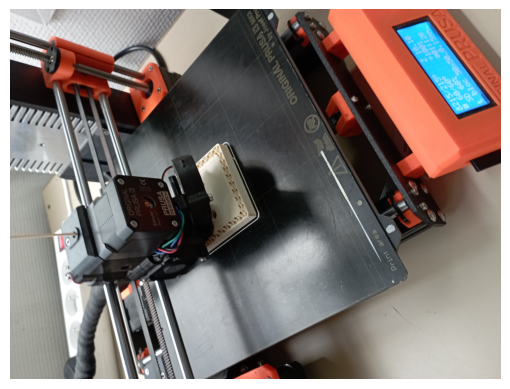

0
1/1 [==============================] - 0s 52ms/step


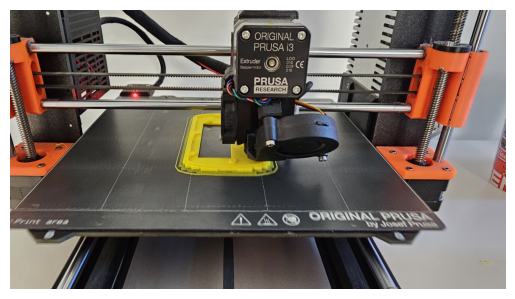

1


In [86]:
vignette_random("testok")

1/1 [==============================] - 0s 19ms/step


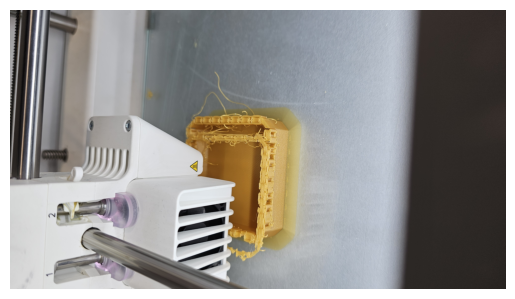

1


In [82]:
vignette_random("testspaghetti")

1/1 [==============================] - 0s 18ms/step


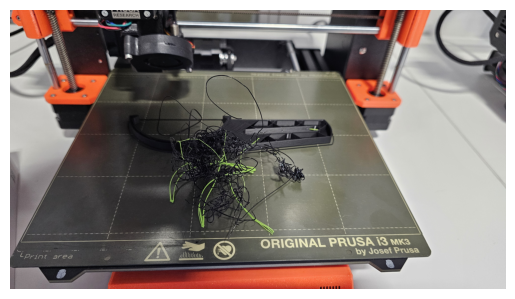

1


In [83]:
vignette_random("testsituationpasok")

1/1 [==============================] - 0s 20ms/step


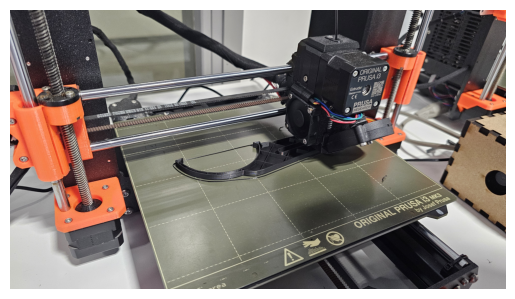

0


In [84]:
vignette_random("testsituationok")